In [1]:
import numpy as np
import metrolopy as uc
import matplotlib.pyplot as plt
import matplotlib.patches as patches

uc.gummy.style = '+-'

colorA = "#FF0000"
colorB = "#0000FF"

In [2]:
def read_file(path):
    with open(path, "r", encoding='ISO-8859-1') as file:
        for _ in range(30):
            next(file) # skip header

        Strom = []
        Spannung = []
        
        for zeile in file:
            werte = zeile.split() # Teilen der Zeile in Werte
            strom = float(werte[0])  # "current"
            spannung = float(werte[1])  # "voltage"
            Strom.append(strom)
            Spannung.append(spannung)

    return Strom, Spannung

def fit_data(Strom, Spannung):
    fit = uc.PolyFit(Strom, Spannung, deg=1)

    steigung = fit.pf[1]
    offset = fit.pf[0]
    usteigung = fit.p[1].u
    
    return steigung, offset, usteigung

def plot_data(ax, PlotTitle, StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt):
    # Plot data points
    ax.scatter(np.array(StromHeiß)*10**6, np.array(SpannungHeiß)*10**6, label='Data hot', s=2, color=colorA)
    ax.scatter(np.array(StromKalt)*10**6, np.array(SpannungKalt)*10**6, label='Data cold', s=2, color=colorB)

    # Plot fit
    Strom = np.linspace(np.min(StromHeiß), np.max(StromHeiß), 100)
    SpannungHeißFit = FitSteigungHeiß * Strom + FitOffsetHeiß
    SpannungKaltFit = FitSteigungKalt * Strom + FitOffsetKalt
    ax.plot(Strom*10**6, SpannungHeißFit*10**6, label=r'Fit hot (second measurement):'+'\n'+r'$U = R \cdot I+U_0$'+'\n'+r'$R = {:.6f} \, \Omega$'.format(FitSteigungHeiß), color=colorA)
    ax.plot(Strom*10**6, SpannungKaltFit*10**6, label=r'Fit cold (second measurement):'+'\n'+r'$U = R \cdot I+U_0$'+'\n'+r'$R = {:.2f} \, \Omega$'.format(FitSteigungKalt), color=colorB)

    ax.set_title(PlotTitle)
    ax.set_xlabel('Current U [µA]')
    ax.set_ylabel('Voltage V [µV]')
    ax.legend(markerscale=2.)

In [12]:
fig = plt.figure(figsize=(15, 10), dpi=700)

Temperature, ResistanceHeiß, uResistanceHeiß, ResistanceKalt, uResistanceKalt = (np.zeros(3) for _ in range(5))

# The rectangle in plot 1
(x,y,xwidth,ywidth)=(4.5,64,0.8,15)
rect1 = patches.Rectangle((x,y),xwidth,ywidth, facecolor='none', edgecolor='black')
plt.subplot(2,3,1).plot([x,x+1.6],[y,10], color='black')
plt.subplot(2,3,1).plot([x+xwidth,10],[y+ywidth,10+60], color='black')
(x,y,xwidth,ywidth)=(6,10,4.5,60)
rect2 = patches.Rectangle((x,y),xwidth,ywidth, facecolor='none', edgecolor='black')
plt.subplot(2,3,1).add_patch(rect1)
plt.subplot(2,3,1).add_patch(rect2)

ax = plt.axes([0.193, 0.615, 0.095, 0.075])
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.axis("off")

for i,pathtuple in enumerate((
    (("T302/2024-06-28_12-07-00 0001 T302_I0_RMessung(1,8,16,9).txt", "T302/2024-06-28_12-07-28 0001 T302_I0_RMessung(15,10,14,11).txt", "T=302K"),
    ("T302/2024-06-28_12-36-07 0001 T302_I0_ZweiteMessung_RMessung(1,8,16,9).txt", "T302/2024-06-28_12-36-34 0001 T302_I0_ZweiteMessung_RMessung(15,10,14,11).txt", "T=302K")),
    (("T306/2024-06-28_12-53-14 0001 T306_I0_RMessung(1,8,16,9).txt", "T306/2024-06-28_12-53-42 0001 T306_I0_RMessung(15,10,14,11).txt", "T=306K"),
    ("T306/2024-06-28_13-17-59 0001 T306_I0_RzweiteMessung(1,8,16,9).txt","T306/2024-06-28_13-18-26 0001 T306_I0_RzweiteMessung(15,10,14,11).txt", "T=306K")),
    (("T308/2024-06-28_13-22-25 0001 T308_I0_R(1,8,16,9).txt", "T308/2024-06-28_13-22-52 0001 T308_I0_R(15,10,14,11).txt", "T=308K"),
    ("T308/2024-06-28_13-48-29 0001 T308_I0_RMessung(1,8,16,9).txt", "T308/2024-06-28_13-48-56 0001 T308_I0_RMessung(15,10,14,11).txt", "T=308K")),
)):
    for (path1, path2, plottitle) in pathtuple:
        StromHeiß, SpannungHeiß = read_file(path1)
        StromKalt, SpannungKalt = read_file(path2)

        FitSteigungHeiß, FitOffsetHeiß, FitUnsicherheitSteigungHeiß = fit_data(StromHeiß, SpannungHeiß)
        print(FitSteigungHeiß, FitUnsicherheitSteigungHeiß)
        FitSteigungKalt, FitOffsetKalt, FitUnsicherheitSteigungKalt = fit_data(StromKalt, SpannungKalt)
        print(FitSteigungKalt, FitUnsicherheitSteigungKalt)

        Temperature[i] = int(plottitle[2:5])
        ResistanceHeiß[i] += FitSteigungHeiß / 2
        uResistanceHeiß[i] += FitUnsicherheitSteigungHeiß / 2
        ResistanceKalt[i] += FitSteigungKalt / 2
        uResistanceKalt[i] += FitUnsicherheitSteigungKalt / 2

        if i == 0:
            x = np.linspace(0,1,8)
            ax.plot(x, 0.8*x+0.2, color=colorB)
            ax.plot(x, 0.83*x+0.0, color=colorB)
            ax.scatter(x, 0.8*x+0.2, marker="^", color=colorB, s=20, label="Data first measurement")
            ax.scatter(x, 0.83*x+0.0, marker="s", color=colorB, s=14, label="Data second measurement")

    plot_data(plt.subplot(2,3,i+1), plottitle, StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

# The plot below
fitHeißSteigung, fitHeißOffset, _ =  fit_data(Temperature, ResistanceHeiß)
fitKaltSteigung, fitKaltOffset, _ =  fit_data(Temperature, ResistanceKalt)

plt.subplots_adjust(hspace=0.3, wspace=0.3, top=0.95, bottom=0.1, left=0.05, right=0.95)
ax = plt.axes([0.05, 0.05, 0.5, 0.4])
ax.scatter(Temperature, ResistanceHeiß, label='Averaged fit parameters (hot side)', s=32, color=colorA, marker='v')
ax.scatter(Temperature, ResistanceKalt, label='Averaged fit parameters (cold side)', s=32, color=colorB, marker='p')
Temperature = np.linspace(np.min(Temperature), np.max(Temperature), 100)
ResistanceHeißFit = fitHeißSteigung * Temperature + fitHeißOffset
ResistanceKaltFit = fitKaltSteigung * Temperature + fitKaltOffset
ax.plot(Temperature, ResistanceHeißFit, label=r'Fit hot: $R = a \cdot T + b$'+'\n'+r'$a = {:.2f} \, m\Omega/K$'.format(fitHeißSteigung*1000), color=colorA)
ax.plot(Temperature, ResistanceKaltFit, label=r'Fit cold: $R = a \cdot T + b$'+'\n'+r'$a = {:.2f} \, m\Omega/K$'.format(fitKaltSteigung*1000), color=colorB)
ax.set_title('Resistance (fit parameter average of first/second measurement) vs. Temperature')
ax.set_xlabel('Temperature T [K]')
ax.set_ylabel(r'Resistance $R$ [Ohm]')
ax.set_ylim(13.5, 24)
ax.legend()

22.220933992603253 0.001064593626854655
14.892251212191852 0.0013772343039243555
22.2289621654228 0.0007380111121155296
14.928090601361307 0.0005824211504827899
22.447697454386738 0.0008333373407853479
15.082178553014424 0.0004500048065004446
22.465733670409325 0.0007090350762396446
15.087115562742033 0.0003746600558100845
22.471983879031477 0.0009907703108360205
15.112260245972385 0.0005167240282017215
22.594642386919123 0.0010940601778714055
15.181562889679247 0.0004879767869443827


5.552019000608992
-1.3893684939778408


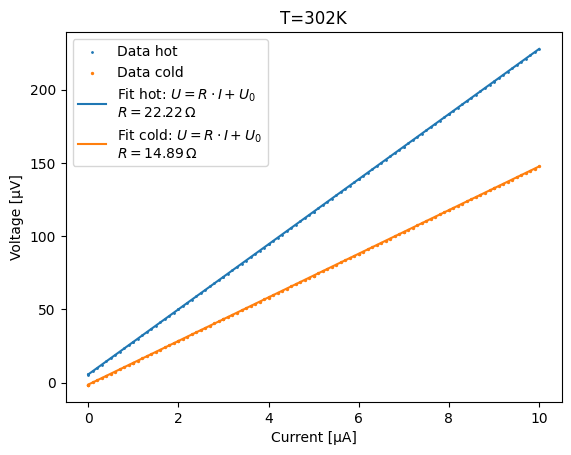

In [71]:
StromHeiß, SpannungHeiß = read_file("T302/2024-06-28_12-07-00 0001 T302_I0_RMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T302/2024-06-28_12-07-28 0001 T302_I0_RMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=302K', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

5.198255884084443
-1.4621976143635738


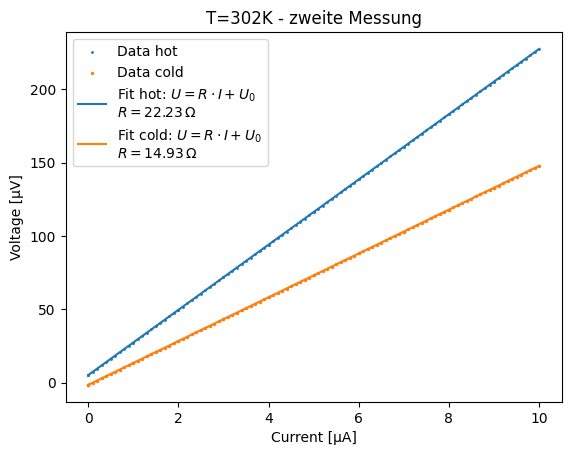

In [78]:
StromHeiß, SpannungHeiß = read_file("T302/2024-06-28_12-36-07 0001 T302_I0_ZweiteMessung_RMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T302/2024-06-28_12-36-34 0001 T302_I0_ZweiteMessung_RMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=302K - zweite Messung', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

5.240960295422239
-1.1954628996244114


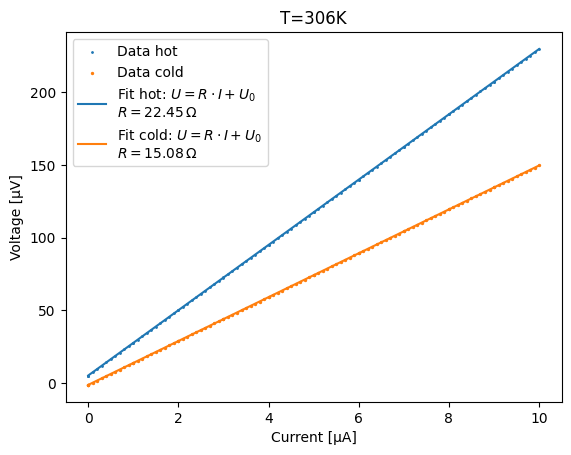

In [72]:
StromHeiß, SpannungHeiß = read_file("T306/2024-06-28_12-53-14 0001 T306_I0_RMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T306/2024-06-28_12-53-42 0001 T306_I0_RMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=306K', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

5.043586297097052
-1.1647900411439058


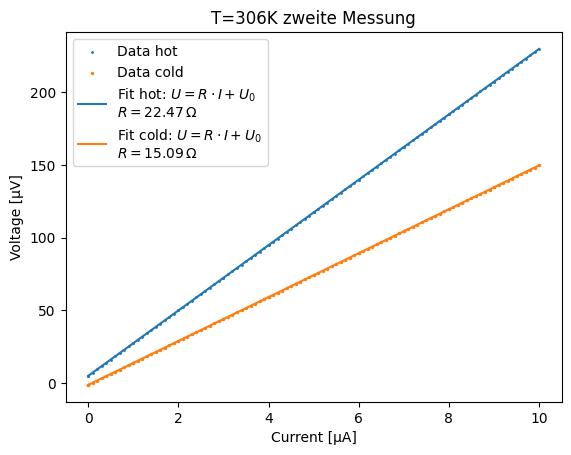

In [82]:
StromHeiß, SpannungHeiß = read_file("T306/2024-06-28_13-17-59 0001 T306_I0_RzweiteMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T306/2024-06-28_13-18-26 0001 T306_I0_RzweiteMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=306K - zweite Messung', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

4.762856219041854
-1.1510855284358315


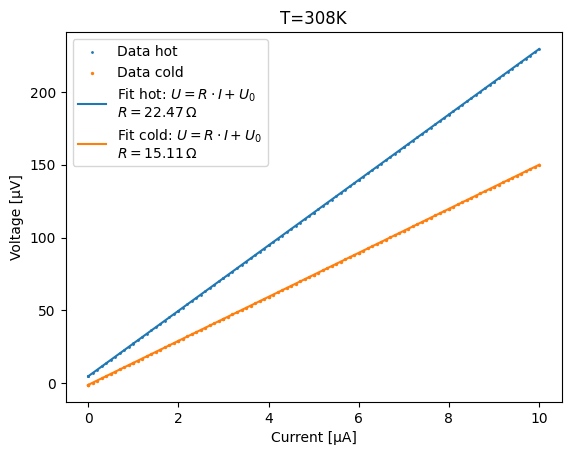

In [75]:
StromHeiß, SpannungHeiß = read_file("T308/2024-06-28_13-22-25 0001 T308_I0_R(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T308/2024-06-28_13-22-52 0001 T308_I0_R(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=308K', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)

5.2411962785221755
-1.0029323939606118


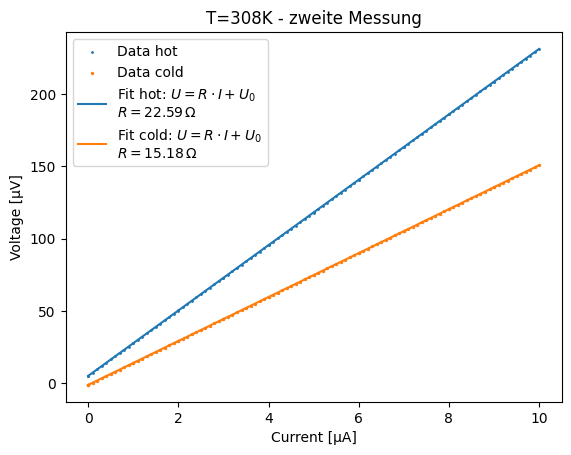

In [81]:
StromHeiß, SpannungHeiß = read_file("T308/2024-06-28_13-48-29 0001 T308_I0_RMessung(1,8,16,9).txt")
StromKalt, SpannungKalt = read_file("T308/2024-06-28_13-48-56 0001 T308_I0_RMessung(15,10,14,11).txt")

FitSteigungHeiß, FitOffsetHeiß = fit_data(StromHeiß, SpannungHeiß)
FitSteigungKalt, FitOffsetKalt = fit_data(StromKalt, SpannungKalt)

plot_data('T=308K - zweite Messung', StromHeiß, SpannungHeiß, StromKalt, SpannungKalt, FitSteigungHeiß, FitOffsetHeiß, FitSteigungKalt, FitOffsetKalt)